In [ ]:
# download VOC testing 2007
%mkdir datasets
%cd datasets
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
!tar xf VOCtest_06-Nov-2007.tar

# download label file and label images
%cd /content/datasets
!wget https://raw.githubusercontent.com/jacksonhawk/EECE570Project/main/voc_label.py
!python voc_label.py

# copy format to YOLOV5 format
%mkdir /content/datasets/VOC
%mkdir /content/datasets/VOC/images
%cp -r /content/datasets/VOCdevkit/VOC2007/JPEGImages/ /content/datasets/VOC/images/
# rename
import os

old_name = r"/content/datasets/VOC/images/JPEGImages"
new_name = r"/content/datasets/VOC/images/test2007"
os.rename(old_name, new_name)

%mkdir /content/datasets/VOC/labels
%cp -r /content/datasets/VOCdevkit/VOC2007/labels/ /content/datasets/VOC/labels/
old_name = r"/content/datasets/VOC/labels/labels"
new_name = r"/content/datasets/VOC/labels/test2007"
os.rename(old_name, new_name)

#get txt and yaml file for VOC
%cd /content/datasets/VOC
!wget https://raw.githubusercontent.com/jacksonhawk/EECE570Project/main/customTrainingVoc.txt
!wget https://raw.githubusercontent.com/jacksonhawk/EECE570Project/main/customTestingVoc.txt
!wget https://raw.githubusercontent.com/jacksonhawk/EECE570Project/main/customValidationVoc.txt
!wget https://raw.githubusercontent.com/jacksonhawk/EECE570Project/main/VOC.yaml
!wget https://raw.githubusercontent.com/jacksonhawk/EECE570Project/main/VocClasses.txt

/content/YOLOV3/datasets
--2023-04-21 16:03:46--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 451020800 (430M) [application/x-tar]
Saving to: ‘VOCtest_06-Nov-2007.tar’

VOCtest_06-Nov-2007  15%[==>                 ]  64.62M  22.2MB/s               ^C
tar: Unexpected EOF in archive
tar: rmtlseek not stopped at a record boundary
tar: Error is not recoverable: exiting now
/content/datasets
--2023-04-21 16:03:51--  https://raw.githubusercontent.com/jacksonhawk/EECE570Project/main/voc_label.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response..

OSError: ignored

In [ ]:
%cd /content/datasets/
%mkdir coco
%cd /content/datasets/coco
# get COCO 2014 Validation Set
!wget http://images.cocodataset.org/zips/val2014.zip
!unzip /content/datasets/coco/val2014.zip -d /content/datasets/coco/images
# get Redmon et al, coco labels
!wget -c https://pjreddie.com/media/files/coco/labels.tgz
!tar xzf labels.tgz
!wget https://raw.githubusercontent.com/jacksonhawk/EECE570Project/main/cocoClasses.txt

This batch of code is used to setup the functions needed for both the YOLO-V3 and YOLO-V5 algorithms

In [ ]:
from pathlib import Path
import torch
import torchvision
import cv2
from google.colab.patches import cv2_imshow
import math
import numpy as np

# function used for the output layers in YOLOV3
# this is layers 82,94,106
def getV3OutputLayers(net):
    
    layerNames = net.getLayerNames()
    outputLayers = [layerNames[i - 1] for i in net.getUnconnectedOutLayers()]

    return outputLayers

# function to draw a bounding box on image
# format is coordinates of top left (x1,x2) and bottom right (x2,y2) pixel locations
# img is a numpy array
def drawBoundingBox(img, classId, confidence, x1, y1, x2, y2):

    label = str(classes[classId]) + ' ' + str(round(confidence,3)) # check classes file for class name
    colour = COLOURS[classId] # get a colour generated for that specific classId

    cv2.rectangle(img, (x1,y1), (x2,y2), colour, 2) # use cv2 module to draw boxes and write label
    cv2.putText(img, label, (x1-10,y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, colour, 2)

# this function takes an imageId file as input of form *.txt and checks the label directory for the ground truth labels
def getGroundTruth(imageID):
  txtPath = Path('/content/datasets/coco/labels/val2014/'+str(imageID))
  
  # read all lines in text file
  with open (txtPath,'r') as f:
    lines = f.readlines()

    # initialize lists
    groundTruthClasses = []
    groundTruthBoxes = [[] for i in range(len(lines))]
    # loop through each line in txt file
    # txt file lines are of format classId center x coordinate, center y coordinate, box width, box height
    for i in range(0,len(lines)):
      splitLine = lines[i].split(" ") # split at spaces
      groundTruthClasses.append(splitLine[0])
      for ind in splitLine[1:5]: # convert strings to floats for calcualtions later
        groundTruthBoxes[i].append(float(ind))

    groundTruthClasses = [int(x) for x in groundTruthClasses] # convert classes to ints

    return groundTruthClasses,groundTruthBoxes

def getAP(guessedClasses,guessedBoxes,groundTruthClasses,groundTruthBoxes):
  # set IOU threshold
  iouThreshold = 0.5
  # intialize True positive, false postive, false negative
  TP = 0
  FP = 0
  FN = 0
  
  for i in range(0,len(guessedClasses)): # loop through each value in guessedClasses
    minDist = 10000 # set intial minDist as a large amount 
    minIndex = 0
    for idx, value in enumerate(groundTruthClasses): # check each value of groundTruth
      if value == guessedClasses[i]: # find matching classes
        dist = math.dist(guessedBoxes[i][0:2],groundTruthBoxes[idx][0:2]) # compute distance

        if dist<minDist: # if the minDist update index
          minIndex = idx
          minDist = dist

    if guessedClasses[i] == groundTruthClasses[minIndex]: # find matching classes at minIndex
      guessedBbox = guessedBoxes[i]
      groundTruthBbox = groundTruthBoxes[minIndex]

      # now can calculate IOU get (x, y)-coordinates of the intersection
      x1p = guessedBbox[0]-guessedBbox[2]/2
      y1p = guessedBbox[1]-guessedBbox[3]/2
      x2p = guessedBbox[0]+guessedBbox[2]/2
      y2p = guessedBbox[1]+guessedBbox[3]/2

      x1g = groundTruthBbox[0]-groundTruthBbox[2]/2
      y1g = groundTruthBbox[1]-groundTruthBbox[3]/2
      x2g = groundTruthBbox[0]+groundTruthBbox[2]/2
      y2g = groundTruthBbox[1]+groundTruthBbox[3]/2
      xA = max(x1p, x1g)
      yA = max(y1p, y1g)
      xB = min(x2p, x2g)
      yB = min(y2p, y2g)

      # compute the area of intersection rectangle
      intersectionArea = max(0, xB - xA) * max(0, yB - yA)

      # compute the area of both the prediction and ground-truth rectangles
      guessedBboxArea = (x2p-x1p)*(y2p-y1p)
      groundTruthBboxArea = (x2g-x1g)*(y2g-y1g)

      # get IOU
      unionArea = float(guessedBboxArea + groundTruthBboxArea - intersectionArea)
      iou = intersectionArea / unionArea
      
      groundTruthClasses.remove(groundTruthClasses[minIndex]) # remove class from groundTruth as to not use it for other predicition
      # to ensure not empty list, add a class ID that doesn't exist so will produce no match
      if (len(groundTruthClasses)==0):

        groundTruthClasses.append(100) # add class that doesn't exist

      if iou>iouThreshold: # if iou is over threshold, it is a true positive, else false positive
        TP = TP+1
      else:
        FP = FP+1
    else: # also increment false positive if no matching class is found
      FP = FP+1

  # false negatives are the remaining classes not removed from groundTruth classes
  # ie there were no predictions found that match that index
  FN = len(groundTruthClasses) if (groundTruthClasses[0]!=100) else 0

  # calcualte the precision and recall
  Precision = TP/(TP+FP)
  Recall = TP/(TP+FN)

  # get average precision and return it
  AveragePrecision = Precision*Recall
  
  return AveragePrecision

# set height and width of image
Width = 256
Height = 256
scale = 0.00392

# read class names from text file
classes = None
with open('/content/datasets/coco/cocoClasses.txt', 'r') as f:
    classes = [line.strip() for line in f.readlines()]

# generate different colors for different classes 
COLOURS = np.random.uniform(0, 255, size=(len(classes), 3))

These next two blocks will get the results for the 40504 COCO images using YOLO-V5

In [ ]:
# gets yoloV5 implementation, as it has a load modle function needed, also gets us the pretrained weights
%cd /content/
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
!pip install -r requirements.txt  # install
!wget https://github.com/ultralytics/yolov5/releases/download/v7.0/yolov5s.pt
%mkdir /content/YOLOV5
%mkdir /content/YOLOV5/results

/content
Cloning into 'yolov5'...
remote: Enumerating objects: 15553, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 15553 (delta 65), reused 101 (delta 47), pack-reused 15393
Receiving objects: 100% (15553/15553), 14.59 MiB | 18.00 MiB/s, done.
Resolving deltas: 100% (10593/10593), done.
/content/yolov5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.2 MB/s eta 0:00:00
--2023-04-20 21:51:53--  https://github.com/ultralytics/yolov5/releases/download/v7.0/yolov5s.pt
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://objects.githubusercontent.com/github-production-release-asset-2e65be/2648

YOLOv5 🚀 v7.0-147-gaa7c45c Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients


[Errno 2] No such file or directory: '/content/datasets/coco/labels/val2014/COCO_val2014_000000010263.txt'
[Errno 2] No such file or directory: '/content/datasets/coco/labels/val2014/COCO_val2014_000000010440.txt'
[Errno 2] No such file or directory: '/content/datasets/coco/labels/val2014/COCO_val2014_000000023017.txt'
[Errno 2] No such file or directory: '/content/datasets/coco/labels/val2014/COCO_val2014_000000090280.txt'
[Errno 2] No such file or directory: '/content/datasets/coco/labels/val2014/COCO_val2014_000000091372.txt'
[Errno 2] No such file or directory: '/content/datasets/coco/labels/val2014/COCO_val2014_000000096923.txt'
[Errno 2] No such file or directory: '/content/datasets/coco/labels/val2014/COCO_val2014_000000125084.txt'
[Errno 2] No such file or directory: '/content/datasets/coco/labels/val2014/COCO_val2014_000000127135.txt'
[Errno 2] No such file or directory: '/content/datasets/coco/labels/val2014/COCO_val2014_000000136173.txt'
[Errno 2] No such file or directory: 

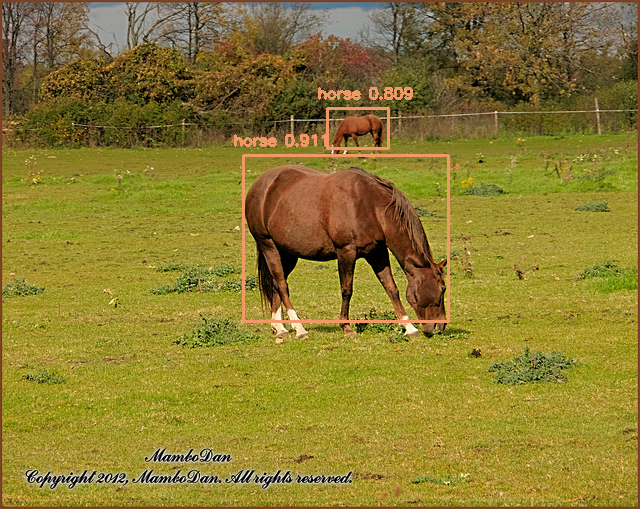

0.39270704952435176
40504
32
129


In [ ]:
import torch
import torchvision
import cv2
import argparse
import numpy as np
from google.colab.patches import cv2_imshow
from pathlib import Path

from models.common import DetectMultiBackend
from utils.dataloaders import LoadImages
from utils.general import (Profile, non_max_suppression, scale_boxes, xyxy2xywh)
from utils.torch_utils import select_device

# saves weights files needed
weights = '/content/yolov5/yolov5s.pt'

numOfImages = 40504
batchSize = 1

# contains classes to guess from
data = '/content/yolov5/data/coco.yaml'
device = select_device('')
# load the model
model = DetectMultiBackend(weights, device=device, dnn=False, data=data, fp16=False)
stride, names, pt = model.stride, model.names, model.pt

# load entire validation 2014 directory and resize to 256 by 256
dataset = LoadImages('/content/datasets/coco/images/val2014', img_size=(256,256), stride=stride, auto=pt, vid_stride=1)
model.warmup(imgsz=(1 if pt or model.triton else batchSize, 3, *(256,256)))  # warmup

# intiliaze variables needed for evaluating performance
seen = 0
mAP = 0
errorImages = 0
missedDetectionImages = 0
#unpack elements of dataset variable
for path, im, im0s, vid_cap, s in dataset:

    # put image on GPU and reshape
    im = torch.from_numpy(im).to(model.device)
    im = im.half() if model.fp16 else im.float()  # uint8 to fp16/32
    im /= 255  # 0 - 255 to 0.0 - 1.0
    if len(im.shape) == 3:
        im = im[None]  # expand for batch dim

    # Inference
    pred = model(im)

    # NMS
    confThreshold = 0.5
    nmsThreshold = 0.4
    pred = non_max_suppression(pred, confThreshold, nmsThreshold, None, False, max_det=1000)

    # loop through all predictions remaining
    for i, det in enumerate(pred):
      seen += 1
      p, im0, frame = path, im0s.copy(), getattr(dataset, 'frame', 0)

      gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh

      # if there is a detection
      if len(det):
        # Rescale boxes to 256 by 256
        det[:, :4] = scale_boxes(im.shape[2:], det[:, :4], im0.shape).round()
        
        guessedBoxes = [[] for i in range(len(det))]
        guessedClasses = []
        guessedConfidences = []
        count = 0
        # save results in same form as ground Truth results
        for *xyxy, conf, cls in reversed(det):
          xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
          guessedBoxes[count].extend(xywh)
          count+=1
          cls = cls.cpu()
          conf = conf.cpu()
          guessedClasses.append(int(cls.numpy()))
          guessedConfidences.append(float(conf.numpy()))

        # implement this in try catch block to accept divide by zero errors, and missing file errors
        try:
          # load the ground truth classes and get the average precision
          groundTruthPath = Path(Path(p).name)
          groundTruthPath = groundTruthPath.with_suffix('.txt')
          groundTruthClasses, groundTruthBoxes = getGroundTruth(groundTruthPath)
          mAP += getAP(guessedClasses,guessedBoxes,groundTruthClasses,groundTruthBoxes)
        except OSError as e: # error for when txt file does not exist
          print(e)
          errorImages +=1
        except ZeroDivisionError: # catch no detection error for when precsion/recall have dievide by zero error
          if (len(groundTruthClasses)):
            missedDetectionImages +=1
          else:
            print("No images detected, but none expected")

        if (seen%1000==0):
          #save 1000th image for analysis
          imWidth = im0.shape[1]
          imHeight = im0.shape[0]
          
          for i in range(0,len(guessedClasses)):
            box = guessedBoxes[i]
            x = (box[0]-box[2]/2)*imWidth
            y = (box[1]-box[3]/2)*imHeight
            w = box[2]*imWidth
            h = box[3]*imHeight

            drawBoundingBox(im0, guessedClasses[i], guessedConfidences[i], round(x), round(y), round(x+w), round(y+h))
          saveImg = Path('/content/YOLOV5/results/'+str(Path(p).name))
          cv2.imwrite(str(saveImg), im0)

# show last image and print results
for i in range(0,len(guessedClasses)):
  box = guessedBoxes[i]
  x = (box[0]-box[2]/2)*imWidth
  y = (box[1]-box[3]/2)*imHeight
  w = box[2]*imWidth
  h = box[3]*imHeight

  drawBoundingBox(im0, guessedClasses[i], guessedConfidences[i], round(x), round(y), round(x+w), round(y+h))

cv2_imshow(im0)
mAP =mAP/(seen-errorImages-missedDetectionImages)
print(mAP)
print(seen)
print(errorImages)
print(missedDetectionImages)

In [ ]:
# code to zip image results so they can be downloaded
!zip -r /content/results.zip /content/YOLOV5/results

  adding: content/YOLOV5/results/ (stored 0%)
  adding: content/YOLOV5/results/COCO_val2014_000000129945.jpg (deflated 0%)
  adding: content/YOLOV5/results/COCO_val2014_000000459884.jpg (deflated 0%)
  adding: content/YOLOV5/results/COCO_val2014_000000273052.jpg (deflated 0%)
  adding: content/YOLOV5/results/COCO_val2014_000000086147.jpg (deflated 0%)
  adding: content/YOLOV5/results/COCO_val2014_000000214871.jpg (deflated 4%)
  adding: content/YOLOV5/results/COCO_val2014_000000387216.jpg (deflated 3%)
  adding: content/YOLOV5/results/COCO_val2014_000000445417.jpg (deflated 1%)
  adding: content/YOLOV5/results/COCO_val2014_000000243810.jpg (deflated 0%)
  adding: content/YOLOV5/results/COCO_val2014_000000315319.jpg (deflated 0%)
  adding: content/YOLOV5/results/COCO_val2014_000000301257.jpg (deflated 0%)
  adding: content/YOLOV5/results/COCO_val2014_000000517515.jpg (deflated 0%)
  adding: content/YOLOV5/results/COCO_val2014_000000574928.jpg (deflated 0%)
  adding: content/YOLOV5/resul

The next two block will create the outputs for all 40504 COCO images using YOLO-**V3** 

In [ ]:
%mkdir /content/YOLOV3
%mkdir /content/YOLOV3/results # folder needed for results
%cd /content/YOLOV3
# downlaoded Redmond et al pretrained weights, and my testing configuration file
!wget https://pjreddie.com/media/files/yolov3.weights
!wget https://raw.githubusercontent.com/jacksonhawk/EECE570Project/main/yolov3Testing.cfg

/content/YOLOV3
--2023-04-21 15:32:26--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  40.1MB/s    in 6.3s    

2023-04-21 15:32:32 (37.5 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2023-04-21 15:32:32--  https://raw.githubusercontent.com/jacksonhawk/EECE570Project/main/yolov3Testing.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8339 (8.1K) [text/plain]
Saving to: ‘yolov3Testing.cfg’

yolov3Testing.cfg   100%[===================>]

In [ ]:
# create a dataset
numOfImages = 40504 # size of COCO 2014 validation set
batchSize = 1

from PIL import Image
import glob

# use glob to load entirety of directory
filelist = glob.glob('/content/datasets/coco/images/val2014/*.jpg')

images = []
imageList = []
# loop through file list and create the imgPaths with .txt suffixes needed to find the ground truth labels
# write images to list using cv2 module, and resize to 256 by 256
for img in range(0,numOfImages):
  imgPath = Path(filelist[img])
  imgPath = imgPath.with_suffix('.txt')
  imgPath = imgPath.name
  im = cv2.imread(filelist[img])
  im = cv2.resize(im,[256,256])
  images.append(im)
  imageList.append(imgPath)


# read pre-trained model, config file, and set to use CUDA
net = cv2.dnn.readNet('/content/YOLOV3/yolov3.weights', '/content/YOLOV3/yolov3Testing.cfg')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

# initialze variables needed for measuring performance
mAP = 0
seen = 0
errorImages = 0
missedDetectionImages = 0

# loop through every image in list
for image in images:

  # create input blob needed to get output from network
  blob = cv2.dnn.blobFromImage(image, scale, (Width,Height), (0,0,0), True, crop=False)

  # set input blob for the network
  net.setInput(blob)

  # get output predctions from layers 82,94,106
  outs = net.forward(getV3OutputLayers(net))

  # initialization
  classIds = []
  confidences = []
  boxes = []
  confThreshold = 0.5
  nmsThreshold = 0.4

  # for each detetion from each output layer 
  # get the confidence, class id, bounding box params
  # and ignore weak detections (confidence < 0.5)
  for out in outs:
      for detection in out:
          scores = detection[5:]
          classId = np.argmax(scores) # get highest confidence of all classes predicited
          confidence = scores[classId]
          if confidence > confThreshold: #if over threshold keep it
              # outputs are of form center x pixel, center y pixel, width, height
              # need to multiple everything by 256 to get relative to image
              centerX = int(detection[0] * Width)
              centerY = int(detection[1] * Height)
              w = int(detection[2] * Width)
              h = int(detection[3] * Height)
              x = centerX - w / 2
              y = centerY - h / 2
              classIds.append(classId)
              confidences.append(float(confidence))
              boxes.append([x, y, w, h])


  # apply non-max suppression
  indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)

  # go through the detections remaining, and append results for comparison
  # also draw bounding box on every 1000th image to see results at end
  guessedBoxes = [[] for i in range(len(indices))]
  guessedClasses = []
  count = 0
  for i in indices:
      box = boxes[i]
      x = box[0]
      y = box[1]
      w = box[2]
      h = box[3]

      # need to convert boxes to relative results 0-1
      # also needs to be of form center x, center y, width, height
      guessedBoxes[count].append((box[0]+box[2]/2)/Width)
      guessedBoxes[count].append((box[1]+box[3]/2)/Height)
      guessedBoxes[count].append((box[2])/Width)
      guessedBoxes[count].append((box[3])/Height)
      guessedClasses.append(classIds[i])
      count = count +1

      if (seen%999==0):
        drawBoundingBox(image, classIds[i], confidences[i], round(x), round(y), round(x+w), round(y+h))
  
  # implement this in try catch block to accept divide by zero errors, and missing file errors
  try:
    # load the ground truth classes and get the average precision
    groundTruthClasses, groundTruthBoxes = getGroundTruth(imageList[seen])
    mAP += getAP(guessedClasses,guessedBoxes,groundTruthClasses,groundTruthBoxes)
  except OSError as e: # this catches error where txt file cannot be found
    print(e)
    errorImages +=1
  except ZeroDivisionError: #this catches error when no predicitons are made and divide by zero error occurs
    if (len(groundTruthClasses)): # make sure there was a prediciton to be made
      missedDetectionImages +=1
    else:
      print("No images detected, but none expected")

  # increment images seen
  seen += 1

  # if the 1000th image save it
  if (seen%1000 == 0):
    saveImg = Path('/content/YOLOV3/results/'+imageList[seen-1])
    saveImg = saveImg.with_suffix('.jpg')
    cv2.imwrite(str(saveImg), image)

# append boxes to last image and display last output image and results
for i in indices:
      #i = i[0]
      box = boxes[i]
      x = box[0]
      y = box[1]
      w = box[2]
      h = box[3]

      drawBoundingBox(image, classIds[i], confidences[i], round(x), round(y), round(x+w), round(y+h))

cv2_imshow(image)
mAP = mAP/(seen-errorImages-missedDetectionImages)
print(mAP)
print(seen)
print(errorImages)
print(missedDetectionImages)


[Errno 2] No such file or directory: '/content/datasets/coco/labels/val2014/COCO_val2014_000000375363.txt'
[Errno 2] No such file or directory: '/content/datasets/coco/labels/val2014/COCO_val2014_000000338067.txt'
[Errno 2] No such file or directory: '/content/datasets/coco/labels/val2014/COCO_val2014_000000283147.txt'
[Errno 2] No such file or directory: '/content/datasets/coco/labels/val2014/COCO_val2014_000000212675.txt'
[Errno 2] No such file or directory: '/content/datasets/coco/labels/val2014/COCO_val2014_000000304036.txt'
[Errno 2] No such file or directory: '/content/datasets/coco/labels/val2014/COCO_val2014_000000401212.txt'
[Errno 2] No such file or directory: '/content/datasets/coco/labels/val2014/COCO_val2014_000000404871.txt'
[Errno 2] No such file or directory: '/content/datasets/coco/labels/val2014/COCO_val2014_000000228415.txt'
[Errno 2] No such file or directory: '/content/datasets/coco/labels/val2014/COCO_val2014_000000404462.txt'
[Errno 2] No such file or directory: 

In [ ]:
# code to zip image results so they can be downloaded
!zip -r /content/results.zip /content/YOLOV3/results

  adding: content/YOLOV3/results/ (stored 0%)
  adding: content/YOLOV3/results/COCO_val2014_000000129945.jpg (deflated 1%)
  adding: content/YOLOV3/results/COCO_val2014_000000086147.jpg (deflated 1%)
  adding: content/YOLOV3/results/COCO_val2014_000000027972.jpg (deflated 0%)
  adding: content/YOLOV3/results/COCO_val2014_000000071209.jpg (deflated 0%)
  adding: content/YOLOV3/results/COCO_val2014_000000056129.jpg (deflated 0%)
  adding: content/YOLOV3/results/COCO_val2014_000000115300.jpg (deflated 1%)
  adding: content/YOLOV3/results/COCO_val2014_000000014226.jpg (deflated 1%)
  adding: content/YOLOV3/results/COCO_val2014_000000100510.jpg (deflated 1%)
  adding: content/YOLOV3/results/COCO_val2014_000000157669.jpg (deflated 1%)
  adding: content/YOLOV3/results/COCO_val2014_000000143825.jpg (deflated 0%)
